In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline

In [3]:
df = pd.read_csv('/content/drive/Othercomputers/drive/drive/Crop_recommendation.csv')

In [4]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [ ]:
print(df['label'].unique())
print(len(df['label'].unique()))

['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']
22


In [ ]:
df['label'].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64

# EDA

### Feature의 분포 확인하기

In [ ]:
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,869 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155455 files and d

In [ ]:
plt.rc('font', family='NanumBarunGothic')

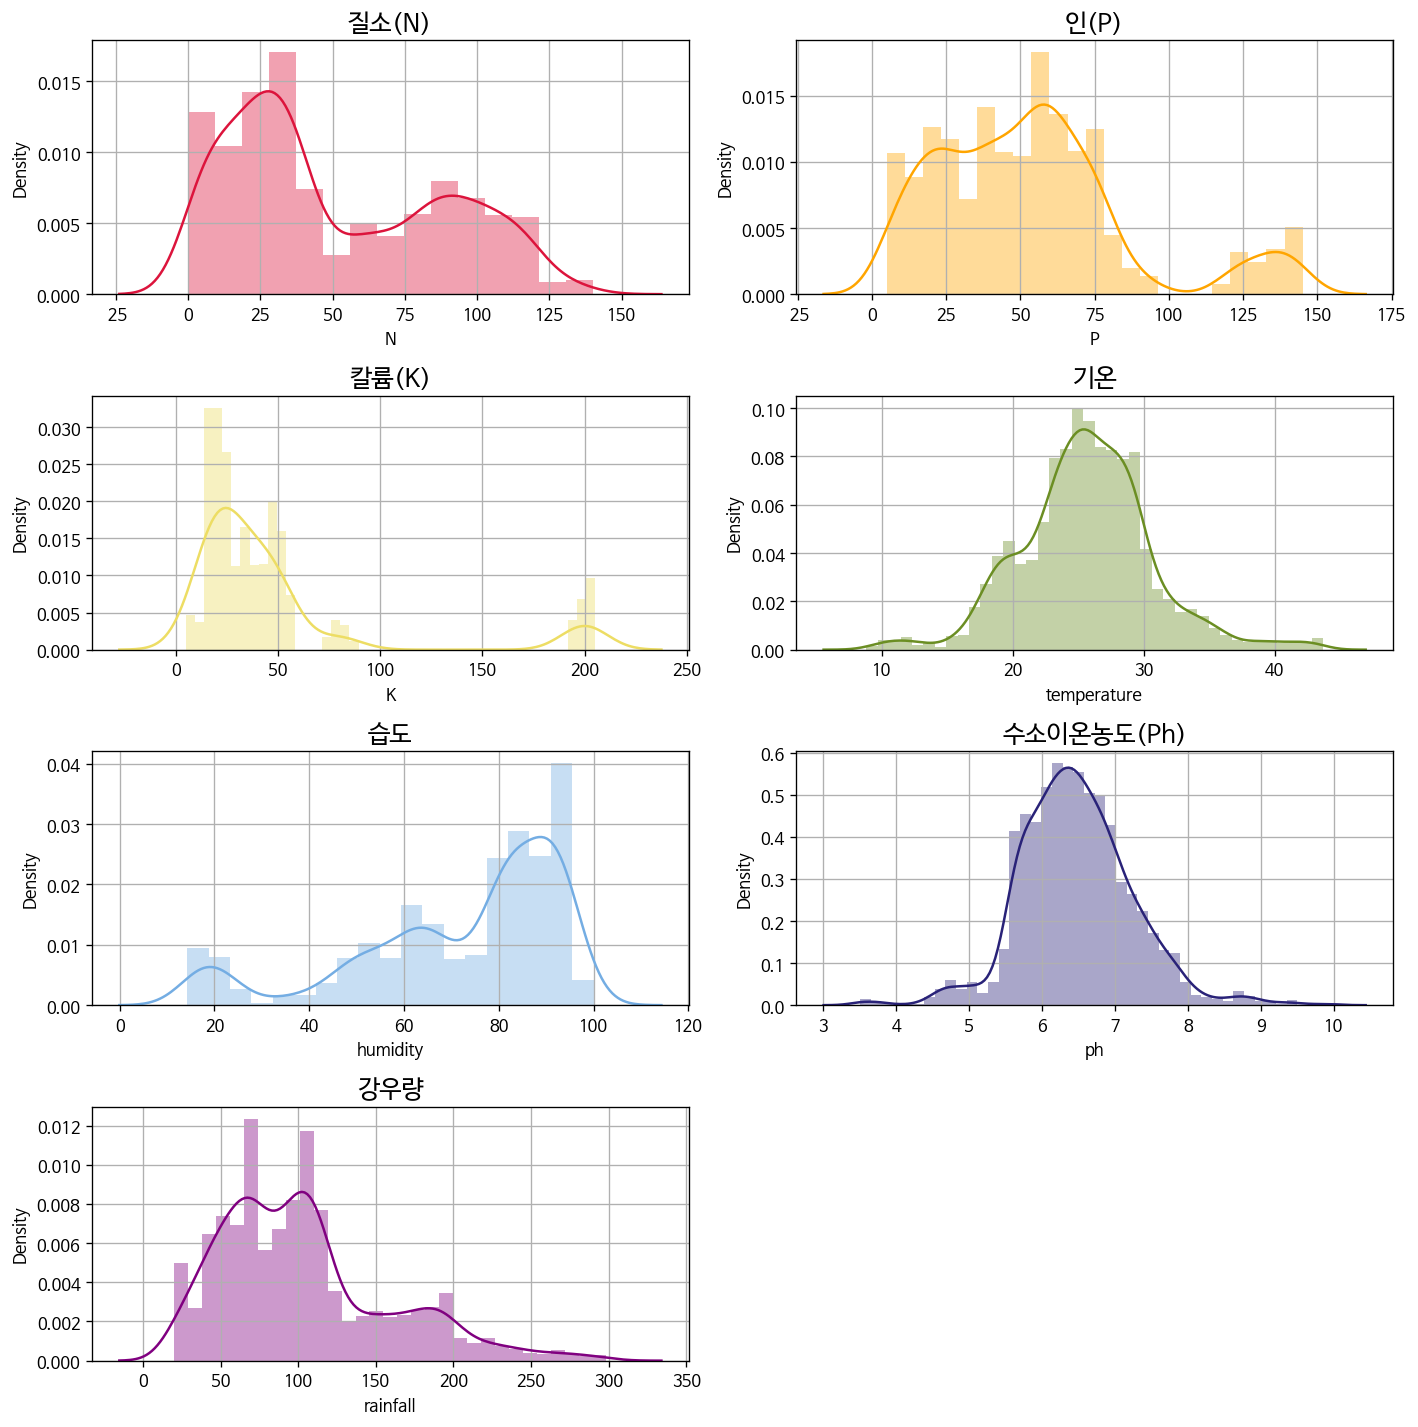

In [ ]:
plt.rcParams['figure.figsize'] = (12, 12)

plt.subplot(4, 2, 1)
sns.distplot(df['N'], color='crimson')
plt.title('질소(N)', fontsize = 15)
plt.tight_layout()
plt.grid()

plt.subplot(4, 2, 2)
sns.distplot(df['P'], color='orange')
plt.title('인(P)', fontsize = 15)
plt.tight_layout()
plt.grid()

plt.subplot(4, 2, 3)
sns.distplot(df['K'], color = '#eddd64')
plt.title('칼륨(K)', fontsize = 15)
plt.tight_layout()
plt.grid()

plt.subplot(4, 2, 4)
sns.distplot(df['temperature'], color = 'olivedrab')
plt.title('기온', fontsize = 15)
plt.tight_layout()
plt.grid()

plt.subplot(4, 2, 5)
sns.distplot(df['humidity'], color = '#74ade3')
plt.title('습도', fontsize = 15)
plt.tight_layout()
plt.grid()

plt.subplot(4, 2, 6)
sns.distplot(df['ph'], color = '#292278')
plt.title('수소이온농도(Ph)', fontsize = 15)
plt.tight_layout()
plt.grid()

plt.subplot(4, 2, 7)
sns.distplot(df['rainfall'], color = 'purple')
plt.title('강우량', fontsize = 15)
plt.tight_layout()
plt.grid()

Feature와 작물

In [ ]:
all_columns = df.columns[:-1]

In [ ]:
colorarr = ['#FFDEAD','#FA8072', '#F0E68C', '#8FBC8F', '#6495ED', '#BA55D3', '#7B68EE','#DC143C', '#FF6347', '#F0E68C', '#BDB76B', '#98FB98',
           '#8FBC8F','#66CDAA','#2E8B57', '#AFEEEE', '#48D1CC', '#008B8B', '#ADD8E6', '#1E90FF', '#4682B4', '#4169E1',
           '#DB7093','#DA70D6','#00ff7f', '#6A5ACD', '#36454f', '#F88379', '#9370DB', '#Ffb347', '#483D8B', '#E75480', '#D8BFD8', '#2F4F4F',
           '#Faf0e6', '#8c92ac', '#Dbd7d2','#A7a6ba', '#B38b6d']

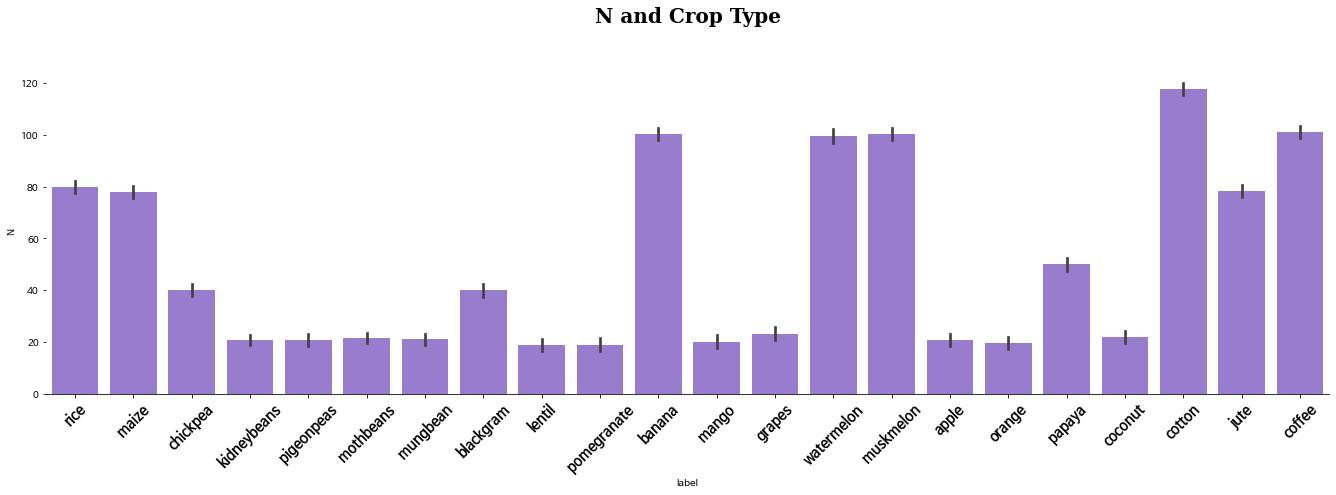

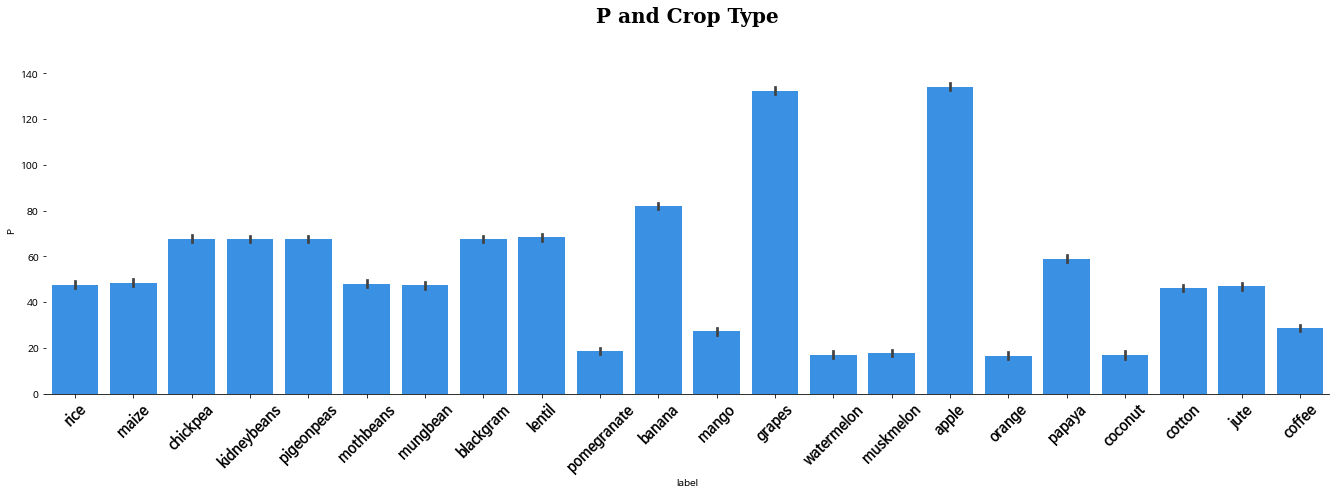

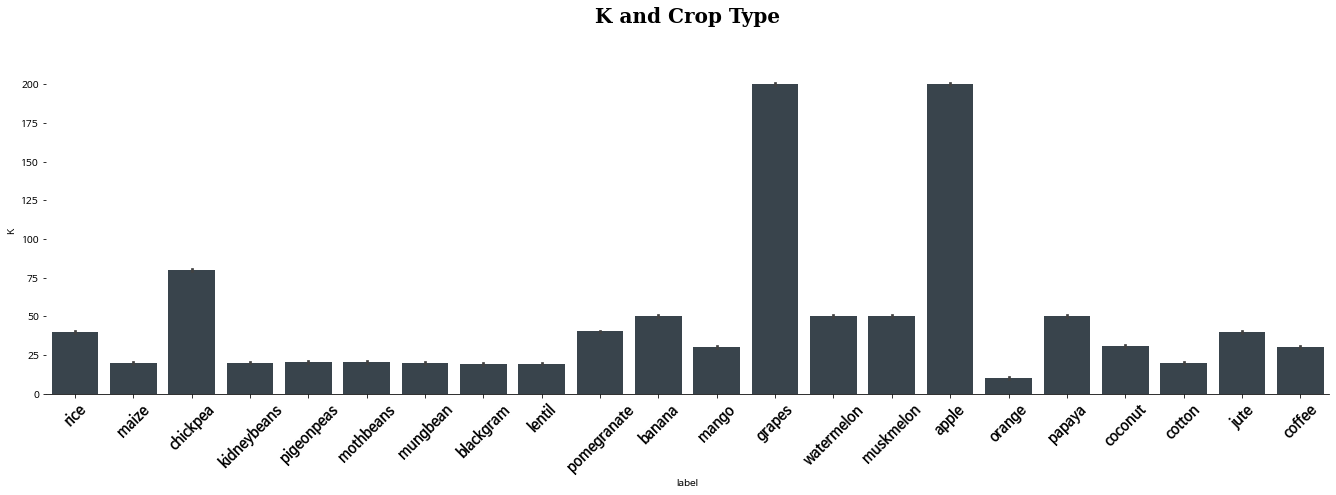

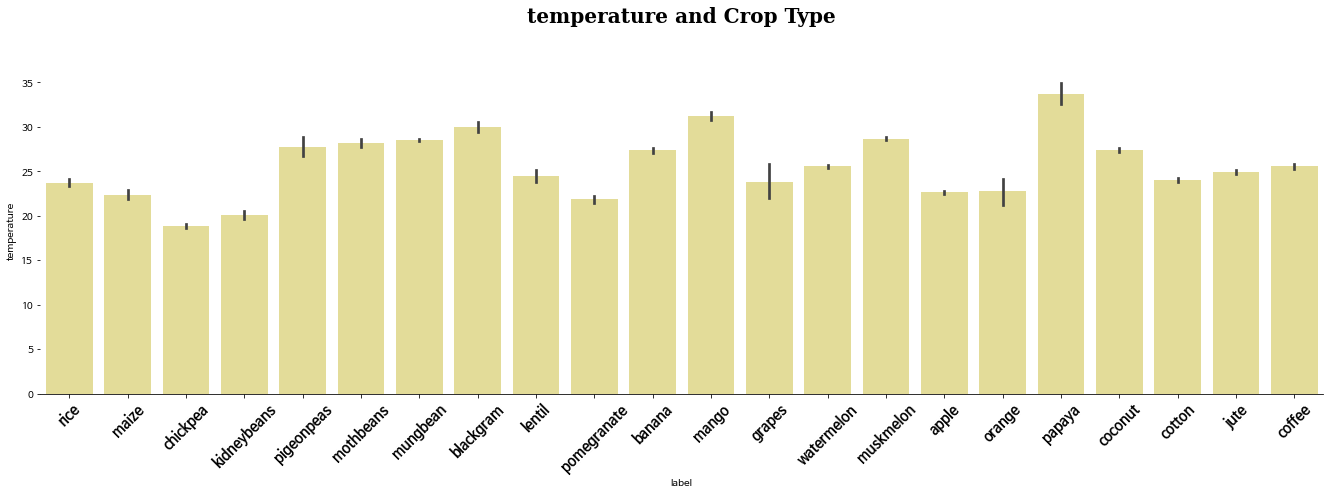

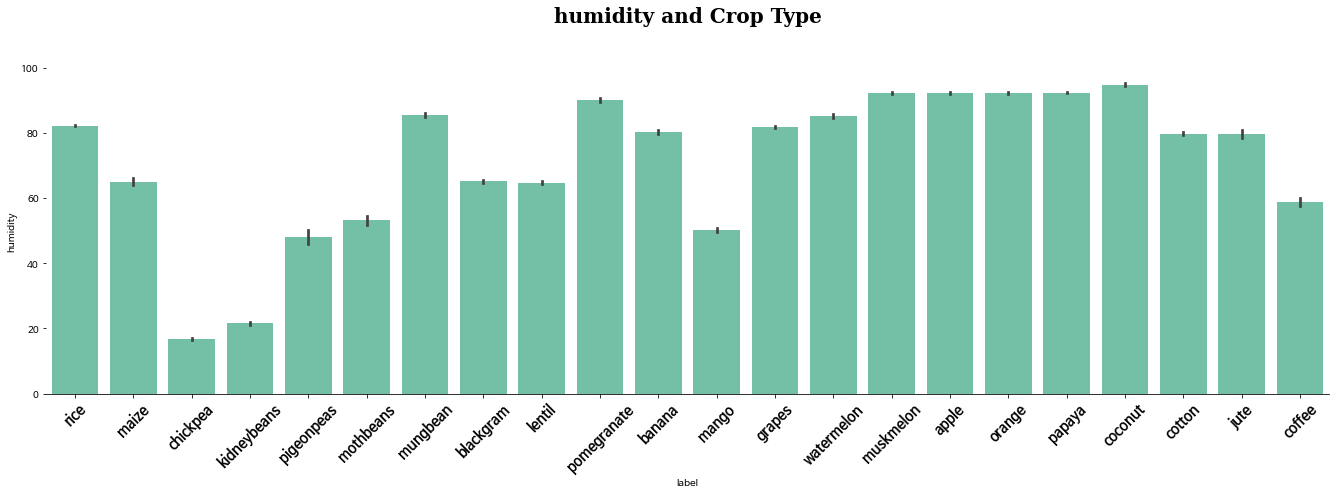

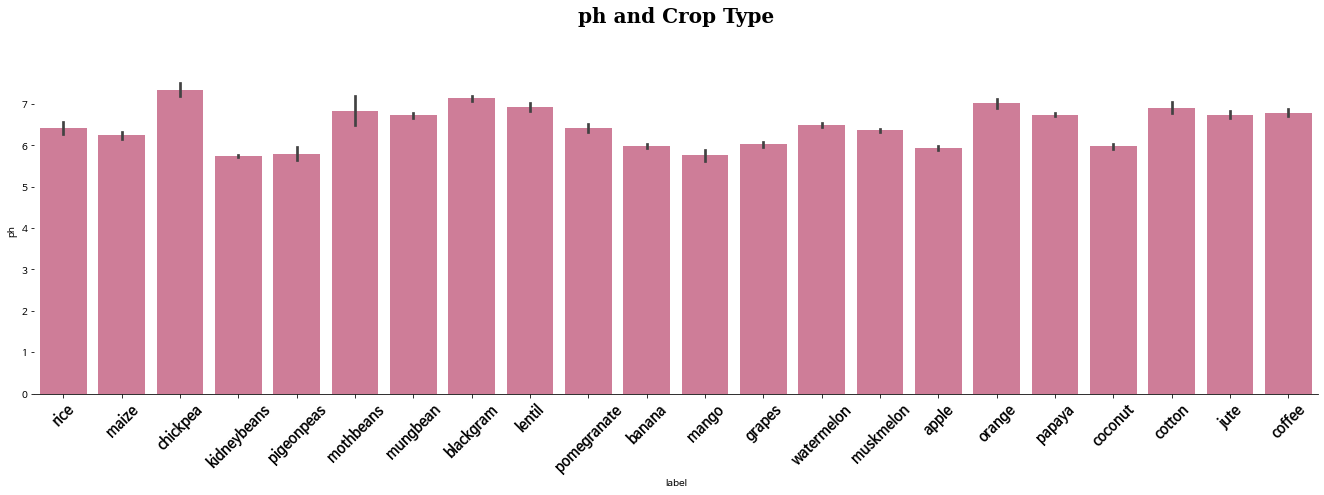

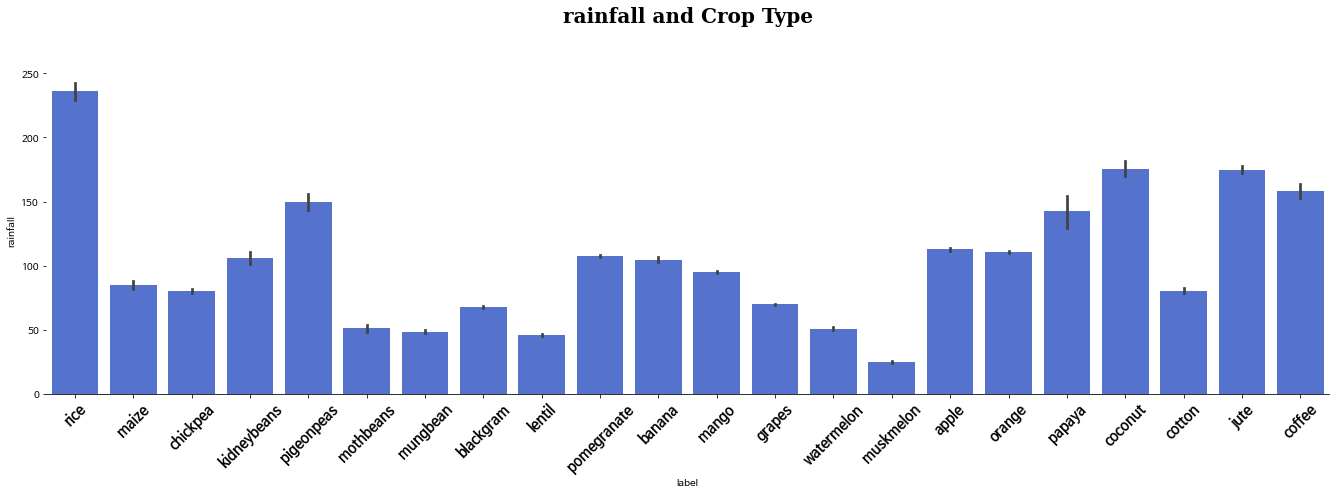

In [ ]:
for column in all_columns:
    plt.figure(figsize=(23,6))
    sns.barplot(x = "label", y = column, data = df,color = random.choice(colorarr))
    plt.xticks(rotation=45, fontsize = 14,fontweight='bold')
    plt.title(f"{column} and Crop Type", fontsize = 20,fontweight='bold', fontfamily='serif',pad=45)
    plt.gca().spines['right'].set_visible(False) 
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.show()

# Modeling

In [5]:
features = df[['N', 'P','K','temperature', 'humidity', 'ph', 'rainfall']]
target = df['label']

In [6]:
acc = []
model = []

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state =2)

### Decision Tree

In [13]:
DecisionTree = DecisionTreeClassifier(criterion="entropy",random_state=2,max_depth=5)

DecisionTree.fit(x_train,y_train)

predicted_values = DecisionTree.predict(x_test)
x = metrics.accuracy_score(y_test, predicted_values)
acc.append(x)
model.append('Decision Tree')

print("Decision Tree Accuracy : ", x*100, "%")

Decision Tree Accuracy :  90.0 %


In [14]:
score = cross_val_score(DecisionTree, features, target,cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.93636364 0.90909091 0.91818182 0.87045455 0.93636364]


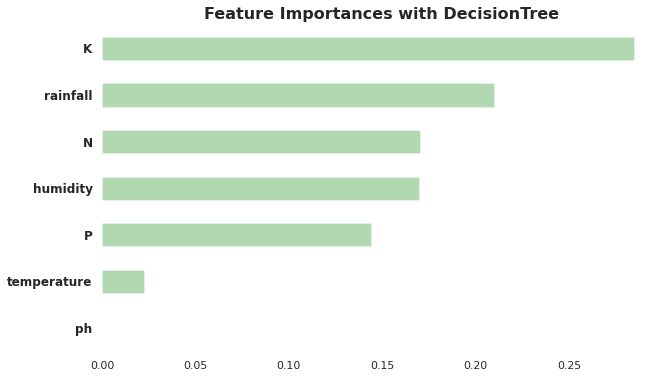

In [75]:
importances_dt = pd.Series(DecisionTree.feature_importances_, x_train.columns)

plt.figure(figsize=(10,6))
plt.title('Feature Importances with DecisionTree',fontsize = 16, fontweight='bold')
plt.yticks(fontsize = 12,fontweight='bold')
plt.box(False)
importances_dt.sort_values()[:].plot.barh(color = 'green', alpha = 0.3);

### RandomForest

In [16]:
RandomForest = RandomForestClassifier(n_estimators=20, random_state=0)
RandomForest.fit(x_train,y_train)

predicted_values = RandomForest.predict(x_test)

x = metrics.accuracy_score(y_test, predicted_values)
acc.append(x)
model.append('Random Forest')
print("Random Forest Accuracy : ", x*100 , "%")

Random Forest Accuracy :  99.0909090909091 %


In [18]:
score = cross_val_score(RandomForest,features,target,cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.99772727 0.99545455 0.99772727 0.99318182 0.98863636]


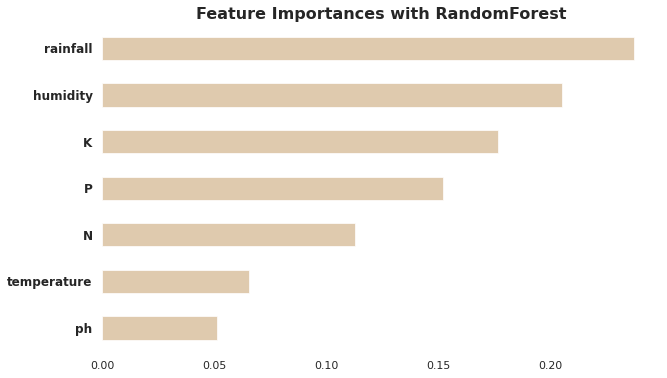

In [86]:
importances_rf = pd.Series(RandomForest.feature_importances_, x_train.columns)

plt.figure(figsize=(10,6))
plt.title('Feature Importances with RandomForest',fontsize = 16, fontweight='bold')
plt.yticks(fontsize = 12,fontweight='bold')
plt.box(False)
importances_rf.sort_values()[:].plot.barh(color = 'tan', alpha = 0.7);

### XGBoost

In [20]:
xgboost = xgb.XGBClassifier()
xgboost.fit(x_train,y_train)

predicted_values = xgboost.predict(x_test)

x = metrics.accuracy_score(y_test, predicted_values);
acc.append(x)
model.append('XGBoost')
print("XGBoost Accuracy : ", x*100 , "%")

XGBoost Accuracy :  99.31818181818181 %


In [89]:
score = cross_val_score(xgboost,features,target,cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.98636364 0.99318182 0.99545455 0.99090909 0.98409091]


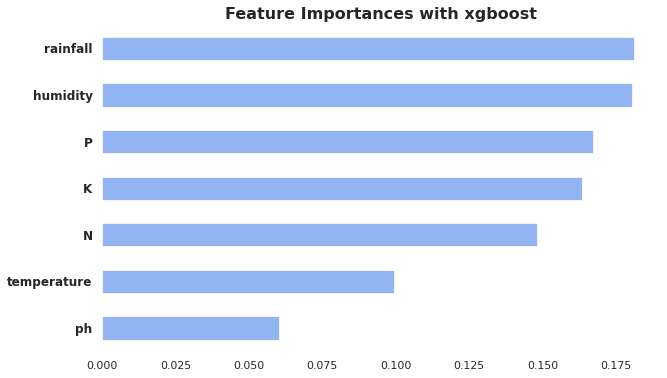

In [88]:
importances_xg = pd.Series(xgboost.feature_importances_, x_train.columns)

plt.figure(figsize=(10,6))
plt.title('Feature Importances with xgboost',fontsize = 16, fontweight='bold')
plt.yticks(fontsize = 12,fontweight='bold')
plt.box(False)
importances_xg.sort_values()[:].plot.barh(color = 'cornflowerblue', alpha = 0.7);

### 정확도 비교

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

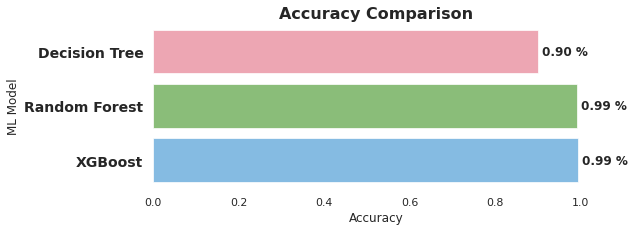

In [84]:
ax = sns.barplot( x = acc,y = model, palette='husl',alpha=0.7)
sns.set(rc={'figure.figsize':(8,3)})

for p in ax.patches:
    x, y, width, height = p.get_bbox().bounds
    ax.text(width*1.01, y+height/2, "%.2f %%"%(width), va='center', fontweight='bold')

plt.box(False)
plt.title('Accuracy Comparison',fontsize = 16, fontweight='bold')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('ML Model', fontsize=12)
plt.yticks(fontsize = 14,fontweight='bold')

### 작물 추천하기

In [96]:
data = np.array([[104,18, 30, 23.603016, 60.3, 6.7, 140.91]])
prediction = RandomForest.predict(data)
print(prediction)

['coffee']
